In [ ]:
import pandas as pd
import json
import numpy as np
from surprise import Dataset, 
import gc

In [2]:
business_path="/home/jaume/Documents/GitHub/Comp_ML/data/yelp_academic_dataset_business.json"
review_path="/home/jaume/Documents/GitHub/Comp_ML/data/yelp_academic_dataset_review.json"

In [3]:
with open(business_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

business = pd.DataFrame(data)
with open(review_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

review = pd.DataFrame(data)

In [ ]:
business_filtered = business[business["city"] == "Sparks"]
business_ids = business_filtered["business_id"]

filtered_reviews= review[review["business_id"].isin(business_ids)]

In [5]:
# Definir umbrales
MIN_USER_REV = 2  # Mínimo de reviews por usuario
MIN_BUSS_REV = 10  # Mínimo de reviews por negocio

# Contar reviews por usuario y negocio
user_counts = filtered_reviews['user_id'].value_counts()
business_counts = filtered_reviews['business_id'].value_counts()

# Filtrar usuarios y negocios con suficientes reviews
filtered_reviews = filtered_reviews[
    (filtered_reviews['user_id'].isin(user_counts[user_counts >= MIN_USER_REV].index)) &
    (filtered_reviews['business_id'].isin(business_counts[business_counts >= MIN_BUSS_REV].index))
]

# Identificar duplicados antes de pivotear
duplicates = filtered_reviews.duplicated(subset=['user_id', 'business_id'], keep=False)

if duplicates.any():
    print("¡Advertencia! Hay usuarios con múltiples reviews para el mismo negocio.")
    print(filtered_reviews[duplicates])


            

¡Advertencia! Hay usuarios con múltiples reviews para el mismo negocio.
                      review_id                 user_id  \
103      D3GVEsKHghesOV5wdZOwRQ  Zp1o52IRl92dunmsfiT96g   
132      1sZkJCitG9-XSlZQJJRs-g  OkN7YI--lQnQhJNdpNubFQ   
216      g7MfpJGKQUGowCvIcrB91A  ci7Q6NvXQ8UZrBHusVX18g   
461      RNf8aUDzK2wzzO7sVzIkbQ  xjQSpme1Z7Xw8XehRLpYuA   
466      tw0NxpoMUREsk2MPLPSx7A  RycuS3TlPJKYCN6jaqgc7w   
...                         ...                     ...   
6988882  oAFj91LidhTkkF9N2qpP_w  hcTjjvDdRYMBSHVTnBuNIg   
6989167  59nVFRJPJd4XIZ7LtVl_Jw  OVoM0VzWh_Mneq-69_GzeQ   
6989543  vu5wD5ooQ--RBuqJMpwRjw  PV7wRAulus-RzEBoJmLyVQ   
6990195  LFl8Xsq7ghHOwSG4XQxU_w  G-uv9J_2-0OyeIlNfHuYjw   
6990223  UKSW7aMzc32KQC_eNwRazg  iTA7VqmHkEX3sUtJLpxHdw   

                    business_id  stars  useful  funny  cool  \
103      gGyqnAlpFrka_qzpO7j4lQ    5.0       0      0     0   
132      C7ZNfxgDQWinNzRfTkevxg    5.0       3      4     3   
216      V6Om7YZhlRQRU7WfuxHq8

In [6]:
from surprise import Dataset, Reader

# Mantener solo las últimas reviews antes de cargar en Surprise
filtered_reviews = (filtered_reviews.sort_values('date')
                    .drop_duplicates(subset=['user_id', 'business_id'], keep='last'))

# Definir el formato de los datos para Surprise
reader = Reader(rating_scale=(1, 5))  # Ajusta según tu escala de calificación
data = Dataset.load_from_df(filtered_reviews[['user_id', 'business_id', 'stars']], reader)

# Construir conjunto de entrenamiento
trainset = data.build_full_trainset()


In [ ]:
import pandas as pd

# Crear una matriz vacía
user_ids = list(trainset.all_users())  # Lista de IDs de usuarios en Surprise
business_ids = list(trainset.all_items())  # Lista de IDs de negocios en Surprise
ratings_matrix = pd.DataFrame(index=user_ids, columns=business_ids)

# Llenar la matriz con las calificaciones disponibles
for u, i, r in trainset.all_ratings():
    ratings_matrix.at[u, i] = r

# Imprimir la matriz resultante
print(ratings_matrix)


In [ ]:
ratings_matrix

,0,1,2,3,4,5,6,7,8,9,...,876,877,878,879,880,881,882,883,884,885
0,3.0,4.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,5.0,3.0,5.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,4.0,NaN,NaN,5.0,4.0,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### USER-BASED RECOMENDEDATIONS

In [ ]:
ratings_user_filled = ratings_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)


/tmp/ipykernel_1272787/1699230609.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ratings_user_filled = ratings_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)


In [ ]:
ratings_user_filled 

,0,1,2,3,4,5,6,7,8,9,...,876,877,878,879,880,881,882,883,884,885
0,3.000000,4.000000,3.000000,3.000000,3.000000,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
1,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,3.000000,5.000000,2.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
2,4.285714,4.285714,4.000000,4.285714,4.285714,5.000000,4.000000,5.000000,4.285714,4.285714,...,4.285714,4.285714,4.285714,4.285714,4.285714,4.285714,4.285714,4.285714,4.285714,4.285714
3,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,4.000000,3.000000,...,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333
4,4.500000,4.500000,5.000000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,...,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,...,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000
9826,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
9827,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
9828,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### BUSINESS-BASED RECOMENDEDATIONS

In [ ]:
ratings_business_filled = ratings_matrix.apply(lambda col: col.fillna(col.mean()), axis=0)


/tmp/ipykernel_1272787/3369165125.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ratings_business_filled = ratings_matrix.apply(lambda col: col.fillna(col.mean()), axis=0)


In [ ]:
ratings_business_filled 

,0,1,2,3,4,5,6,7,8,9,...,876,877,878,879,880,881,882,883,884,885
0,3.000000,4.0,3.000000,3.000000,3.000000,4.348993,4.284974,4.093023,2.633776,2.588785,...,3.8125,4.636364,4.409091,4.282051,3.076923,3.06383,3.526316,4.441176,3.903614,3.975
1,3.727273,2.0,4.073529,3.616667,3.929293,5.000000,3.000000,5.000000,2.000000,2.588785,...,3.8125,4.636364,4.409091,4.282051,3.076923,3.06383,3.526316,4.441176,3.903614,3.975
2,3.727273,2.0,4.000000,3.616667,3.929293,5.000000,4.000000,5.000000,2.633776,2.588785,...,3.8125,4.636364,4.409091,4.282051,3.076923,3.06383,3.526316,4.441176,3.903614,3.975
3,3.727273,2.0,4.073529,3.616667,3.929293,4.348993,4.284974,4.093023,4.000000,3.000000,...,3.8125,4.636364,4.409091,4.282051,3.076923,3.06383,3.526316,4.441176,3.903614,3.975
4,3.727273,2.0,5.000000,3.616667,3.929293,4.348993,4.284974,4.093023,2.633776,2.588785,...,3.8125,4.636364,4.409091,4.282051,3.076923,3.06383,3.526316,4.441176,3.903614,3.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,3.727273,2.0,4.073529,3.616667,3.929293,4.348993,4.284974,4.093023,2.633776,2.588785,...,3.8125,4.636364,4.409091,4.282051,3.076923,3.06383,3.526316,4.441176,3.903614,3.975
9826,3.727273,2.0,4.073529,3.616667,3.929293,4.348993,4.284974,4.093023,2.633776,2.588785,...,3.8125,4.636364,4.409091,4.282051,3.076923,3.06383,3.526316,4.441176,3.903614,3.975
9827,3.727273,2.0,4.073529,3.616667,3.929293,4.348993,4.284974,4.093023,2.633776,2.588785,...,3.8125,4.636364,4.409091,4.282051,3.076923,3.06383,3.526316,4.441176,3.903614,3.975
9828,3.727273,2.0,4.073529,3.616667,3.929293,4.348993,4.284974,4.093023,2.633776,2.588785,...,3.8125,4.636364,4.409091,4.282051,3.076923,3.06383,3.526316,4.441176,3.903614,3.975


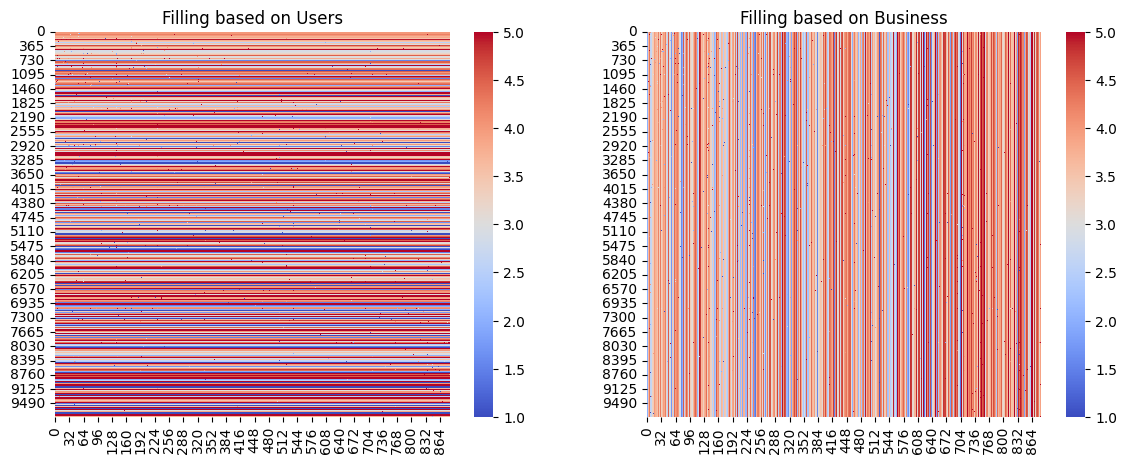

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap del enfoque basado en usuarios
sns.heatmap(ratings_user_filled, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Filling based on Users")

# Heatmap del enfoque basado en negocios
sns.heatmap(ratings_business_filled, cmap="coolwarm", ax=axes[1])
axes[1].set_title("Filling based on Business")

plt.show()

We can see that the filling based on Users, goes to more extreme-reviews, probably due to the lack of reviews from users, and the fact that some users tend to give only 5s and 1s.
On the other hand business filling is more balanced.

In [ ]:
def recommend(model, user_id, business_ids, top_n=10):
    """
    Recommend the top N businesses for a given user based on predicted ratings.
    
    Parameters:
    model: A model that takes (user_id, business_id) as input and predicts a rating between 1 and 5.
    user_id: The ID of the user for whom recommendations are being generated.
    business_ids: A list of business IDs to consider for recommendation.
    top_n: The number of top recommendations to return (default is 10).
    
    Returns:
    A sorted list of (business_id, predicted_rating) tuples, in descending order of predicted rating.
    """
    predictions = [(business_id, model.predict(user_id, business_id)) for business_id in business_ids]
    
    # Sort businesses by predicted rating in descending order and return the top_n
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_n]
    
    return recommendations


def evaluate(model, test_df, threshold=3, top_n=10):
    """
    Evaluate the recommendation model using precision and recall.
    
    Parameters:
    model: A model that predicts ratings for (user_id, business_id) pairs.
    test_df: A DataFrame containing columns ['user_id', 'business_id', 'rating'].
    threshold: The minimum rating to consider a business as relevant (default is 3).
    top_n: The number of top recommendations to consider per user (default is 10).
    
    Returns:
    A tuple (recall, precision) for the model's recommendations.
    """
    total_relevant = 0
    total_recommended = 0
    total_matched = 0
    
    users = test_df['user_id'].unique()
    
    for user_id in users:
        user_data = test_df[test_df['user_id'] == user_id]
        actual_relevant = set(user_data[user_data['rating'] >= threshold]['business_id'])
        
        recommended = set(business_id for business_id, _ in recommend(model, user_id, user_data['business_id'].tolist(), top_n))
        
        total_relevant += len(actual_relevant)
        total_recommended += len(recommended)
        total_matched += len(actual_relevant & recommended)
    
    recall = total_matched / total_relevant if total_relevant > 0 else 0
    precision = total_matched / total_recommended if total_recommended > 0 else 0
    
    return recall, precision